Experimenting with estimating the gender of mailing list participants.

In [166]:
%matplotlib inline

Import the BigBang modules as needed. These should be in your Python environment if you've installed BigBang correctly.

In [153]:
import bigbang.mailman as mailman
import bigbang.graph as graph
import bigbang.process as process
from bigbang.parse import get_date
from bigbang.archive import Archive
import bigbang.utils as utils
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
import pytz
import pickle
import os
import csv
import re
import scipy
import scipy.cluster.hierarchy as sch
from bigbang import parse
from gender_detector import GenderDetector

pd.options.display.mpl_style = 'default' # pandas has a set of preferred graph formatting options
plt.rcParams['axes.facecolor'] = 'white'
import seaborn as sns
sns.set()
sns.set_style("white")

Now let's load the data for analysis.

In [3]:
urls = ["https://lists.w3.org/Archives/Public/w3c-wai-gl",
"https://lists.w3.org/Archives/Public/public-apa",
"https://lists.w3.org/Archives/Public/public-aria-admin",
"https://lists.w3.org/Archives/Public/public-audio",
"https://lists.w3.org/Archives/Public/public-automotive",
"https://lists.w3.org/Archives/Public/public-browser-tools-testing/",
"https://lists.w3.org/Archives/Public/www-style/",
"https://lists.w3.org/Archives/Public/public-dxwg-wg",
"https://lists.w3.org/Archives/Public/public-device-apis",
"https://lists.w3.org/Archives/Public/w3c-wai-eo/",
"https://lists.w3.org/Archives/Public/public-exi",
"https://lists.w3.org/Archives/Public/public-html-media",
"https://lists.w3.org/Archives/Public/public-i18n-core",
"https://lists.w3.org/Archives/Public/public-poe-wg",
"https://lists.w3.org/Archives/Public/public-pointer-events",
"https://lists.w3.org/Archives/Public/public-data-shapes-wg",
"https://lists.w3.org/Archives/Public/public-secondscreen",
"https://lists.w3.org/Archives/Public/public-socialweb",
"https://lists.w3.org/Archives/Public/public-sdw-wg",
"https://lists.w3.org/Archives/Public/public-svg-wg",
"https://lists.w3.org/Archives/Public/public-tt",
"https://lists.w3.org/Archives/Public/public-tracking",
"https://lists.w3.org/Archives/Public/public-vc-wg",
"https://lists.w3.org/Archives/Public/public-webappsec",
"https://lists.w3.org/Archives/Public/public-webauthn",
"https://lists.w3.org/Archives/Public/public-wot-wg",
"https://lists.w3.org/Archives/Public/public-payments-wg",
"https://lists.w3.org/Archives/Public/public-web-perf",
"https://lists.w3.org/Archives/Public/public-webapps",
"https://lists.w3.org/Archives/Public/public-webrtc",
"https://lists.w3.org/Archives/Public/public-webfonts-wg",
"https://lists.w3.org/Archives/Public/public-xsl-query",
"https://lists.w3.org/Archives/Public/public-xsl-wg",
"https://lists.w3.org/Archives/Public/public-digipub-ig",
"https://lists.w3.org/Archives/Public/public-html-ig-zh",
"https://lists.w3.org/Archives/Public/www-international/",
"https://lists.w3.org/Archives/Public/public-i18n-its-ig/",
"https://lists.w3.org/Archives/Public/public-privacy/",
"https://lists.w3.org/Archives/Public/public-semweb-lifesci/",
"https://lists.w3.org/Archives/Public/w3c-wai-ig/",
"https://lists.w3.org/Archives/Public/public-web-and-tv",
#"https://lists.w3.org/Archives/Public/public-wot-ig", # no archives currently
"https://lists.w3.org/Archives/Public/public-webpayments-ig",
"https://lists.w3.org/Archives/Public/public-web-security"]
#mlists = [(url, mailman.open_list_archives(url,"../archives")) for url in urls[:5]]
mlists = [(url, mailman.open_list_archives(url,"../../w3c-archives")) for url in urls]

Opening 80 archive files
Date parsing error on: 
Thu, 3 Jul 2003 04:55:30 0200 
Opening 18 archive files
Opening 16 archive files
Opening 26 archive files
Opening 29 archive files
Opening 23 archive files
Opening 55 archive files
Opening 2 archive files
Opening 101 archive files
Opening 38 archive files
Opening 95 archive files
Opening 52 archive files
Opening 50 archive files
Opening 17 archive files
Opening 20 archive files
Opening 33 archive files
Opening 18 archive files
Opening 39 archive files
Opening 30 archive files
Opening 36 archive files
Opening 140 archive files
Opening 70 archive files
Opening 3 archive files
Opening 69 archive files
Opening 17 archive files
Opening 7 archive files
Opening 21 archive files
Opening 85 archive files
Opening 14 archive files
Opening 75 archive files
Opening 1 archive files
Opening 21 archive files
Opening 17 archive files
Opening 49 archive files
Opening 80 archive files
Opening 85 archive files
Opening 91 archive files
Opening 17 archive fil

For each of our lists, we'll clean up the names, find the first name if there is one, and guess its gender. Pandas groups the data together for comparison. We keep count of the names we find that are ambiguous, for the next step.

In [76]:
detector = GenderDetector('us')

gender_ambiguous_names = {}

def guess_gender(name):
    if not name:
        return 'name unknown'
    try:
        if detector.guess(name) == 'unknown':
            if name in gender_ambiguous_names:
                gender_ambiguous_names[name] += 1
            else:
                gender_ambiguous_names[name] = 1
        
        return detector.guess(name)
    except:
        return 'error'

frames = []
for (url, ml) in mlists:
    activity = Archive.get_activity(Archive(ml))
    
    # TODO: if senders-listname-manual.csv exists, use that for entity resolution and gender inference instead
    
    # some automated entity resolution
    consolidates = process.resolve_sender_entities(activity, lexical_distance=8)
    consolidates_reduced = {k: v for k,v in consolidates.iteritems() if len(v) > 1}
    activity_consolidated = utils.repartition_dataframe(activity, consolidates)

    print 'Removed %d columns from %s.' % (len(activity.columns) - len(activity_consolidated.columns), mailman.get_list_name(url)) 
            
    activityFrame = pd.DataFrame(activity_consolidated.sum(0), columns=['Message Count'])
    
    activityFrame['aka'] = None # new empty column
    for k,v in consolidates_reduced.iteritems():
        activityFrame.ix[k, 'aka'] = ','.join(v)
    
    activityFrame['Name'] = activityFrame.index.map(lambda x: parse.clean_from(x))    
    activityFrame['First Name'] = activityFrame['Name'].map(lambda x: parse.guess_first_name(x))
    activityFrame['Guessed Gender'] = activityFrame['First Name'].map(guess_gender)
    
    activityFrame.to_csv(('senders-%s.csv' % mailman.get_list_name(url)),encoding='utf-8')
    frames.append((url, activityFrame))

Removed 211 columns from w3c-wai-gl.
Removed 5 columns from public-apa.
Removed 1 columns from public-aria-admin.
Removed 37 columns from public-audio.
Removed 2 columns from public-automotive.
Removed 3 columns from public-browser-tools-testing.
Removed 58 columns from www-style.
Removed 0 columns from public-dxwg-wg.
Removed 52 columns from public-device-apis.
Removed 11 columns from w3c-wai-eo.
Removed 9 columns from public-exi.
Removed 38 columns from public-html-media.
Removed 40 columns from public-i18n-core.
Removed 2 columns from public-poe-wg.
Removed 20 columns from public-pointer-events.
Removed 7 columns from public-data-shapes-wg.
Removed 15 columns from public-secondscreen.
Removed 7 columns from public-socialweb.
Removed 11 columns from public-sdw-wg.
Removed 6 columns from public-svg-wg.
Removed 32 columns from public-tt.


/Users/nick/code/mailing-list-analysis/bigbang/bigbang/parse.py:45: UserWarning: "\(unknown char" <info@localpool.com> is hard to clean
  warnings.warn("%s is hard to clean" % (m_from))


Removed 20 columns from public-tracking.
Removed 0 columns from public-vc-wg.
Removed 35 columns from public-webappsec.
Removed 31 columns from public-webauthn.
Removed 0 columns from public-wot-wg.
Removed 40 columns from public-payments-wg.
Removed 17 columns from public-web-perf.
Removed 28 columns from public-webapps.
Removed 39 columns from public-webrtc.
Removed 0 columns from public-webfonts-wg.
Removed 2 columns from public-xsl-query.
Removed 1 columns from public-xsl-wg.
Removed 13 columns from public-digipub-ig.
Removed 60 columns from public-html-ig-zh.
Removed 173 columns from www-international.
Removed 5 columns from public-i18n-its-ig.
Removed 19 columns from public-privacy.
Removed 140 columns from public-semweb-lifesci.
Removed 53 columns from w3c-wai-ig.


/Users/nick/code/mailing-list-analysis/bigbang/bigbang/parse.py:45: UserWarning: "The International Conference on E-Technologies and Business on the Web \(EBW2013" <th@sdiwc.net> is hard to clean
  warnings.warn("%s is hard to clean" % (m_from))


Removed 0 columns from public-web-and-tv.
Removed 8 columns from public-webpayments-ig.
Removed 21 columns from public-web-security.


In [170]:
series = []  

for (url, activityFrame) in frames:
    counts = activityFrame.groupby('Guessed Gender')['Message Count'].sum()
    participants = activityFrame.groupby('Guessed Gender')['Name'].count()
    
    counts_combined = pd.concat([counts, participants], keys=['message count', 'participants'])
    
    counts_combined.name=url
    series.append(counts_combined)

genderFrame = pd.DataFrame(series)

# filter for lists with at least 100 total messages
genderFrame['message count', 'total'] = genderFrame['message count'].sum(axis=1)
genderFrame = genderFrame[genderFrame['message count', 'total'] > 100]
genderFrame

message count          \
Guessed Gender                                             error  female   
https://lists.w3.org/Archives/Public/w3c-wai-gl             12.0  4954.0   
https://lists.w3.org/Archives/Public/public-apa              NaN    42.0   
https://lists.w3.org/Archives/Public/public-ari...           NaN    37.0   
https://lists.w3.org/Archives/Public/public-audio            NaN    11.0   
https://lists.w3.org/Archives/Public/public-aut...           NaN    14.0   
https://lists.w3.org/Archives/Public/public-bro...           NaN    22.0   
https://lists.w3.org/Archives/Public/www-style/             57.0   272.0   
https://lists.w3.org/Archives/Public/public-dev...          18.0   157.0   
https://lists.w3.org/Archives/Public/w3c-wai-eo/             NaN   321.0   
https://lists.w3.org/Archives/Public/public-exi              NaN    13.0   
https://lists.w3.org/Archives/Public/public-htm...           1.0    47.0   
https://lists.w3.org/Archives/Public/public-i18...           2.0    62.0   
https://lists.w3.org/Archives/Public/public-poe-wg           NaN    35.0   
https://lists.w3.org/Archives/Public/public-poi...           NaN    16.0   
https://lists.w3.org/Archives/Public/public-dat...           NaN   882.0   
https://lists.w3.org/Archives/Public/public-sec...           NaN     1.0   
https://lists.w3.org/Archives/Public/public-soc...           NaN   193.0   
https://lists.w3.org/Archives/Public/public-sdw-wg           NaN    10.0   
https://lists.w3.org/Archives/Public/public-svg-wg           NaN    18.0   
https://lists.w3.org/Archives/Public/public-tt               1.0   191.0   
https://lists.w3.org/Archives/Public/public-tra...           2.0   481.0   
https://lists.w3.org/Archives/Public/public-web...          18.0  1561.0   
https://lists.w3.org/Archives/Public/public-web...        1397.0    64.0   
https://lists.w3.org/Archives/Public/public-pay...           NaN    15.0   
https://lists.w3.org/Archives/Public/public-web...           1.0   106.0   
https://lists.w3.org/Archives/Public/public-web...          22.0   564.0   
https://lists.w3.org/Archives/Public/public-webrtc           NaN   146.0   
https://lists.w3.org/Archives/Public/public-xsl...           NaN     8.0   
https://lists.w3.org/Archives/Public/public-xsl-wg           NaN    12.0   
https://lists.w3.org/Archives/Public/public-dig...           1.0   234.0   
https://lists.w3.org/Archives/Public/public-htm...          21.0     7.0   
https://lists.w3.org/Archives/Public/www-intern...           8.0   420.0   
https://lists.w3.org/Archives/Public/public-i18...           NaN     9.0   
https://lists.w3.org/Archives/Public/public-pri...           NaN   219.0   
https://lists.w3.org/Archives/Public/public-sem...           NaN  1298.0   
https://lists.w3.org/Archives/Public/w3c-wai-ig/             NaN   739.0   
https://lists.w3.org/Archives/Public/public-web...           2.0   173.0   
https://lists.w3.org/Archives/Public/public-web...           NaN    49.0   

                                                                          \
Guessed Gender                                         male name unknown   
https://lists.w3.org/Archives/Public/w3c-wai-gl     19421.0       5432.0   
https://lists.w3.org/Archives/Public/public-apa       226.0        251.0   
https://lists.w3.org/Archives/Public/public-ari...    341.0         39.0   
https://lists.w3.org/Archives/Public/public-audio    3665.0       1808.0   
https://lists.w3.org/Archives/Public/public-aut...    511.0        101.0   
https://lists.w3.org/Archives/Public/public-bro...    784.0        936.0   
https://lists.w3.org/Archives/Public/www-style/     16110.0       2178.0   
https://lists.w3.org/Archives/Public/public-dev...   3207.0       1553.0   
https://lists.w3.org/Archives/Public/w3c-wai-eo/      959.0        247.0   
https://lists.w3.org/Archives/Public/public-exi       252.0        156.0   
https://lists.w3.org/Archives/Public/public-htm...   1479.0        480.0   
https://lists.w3.org/A

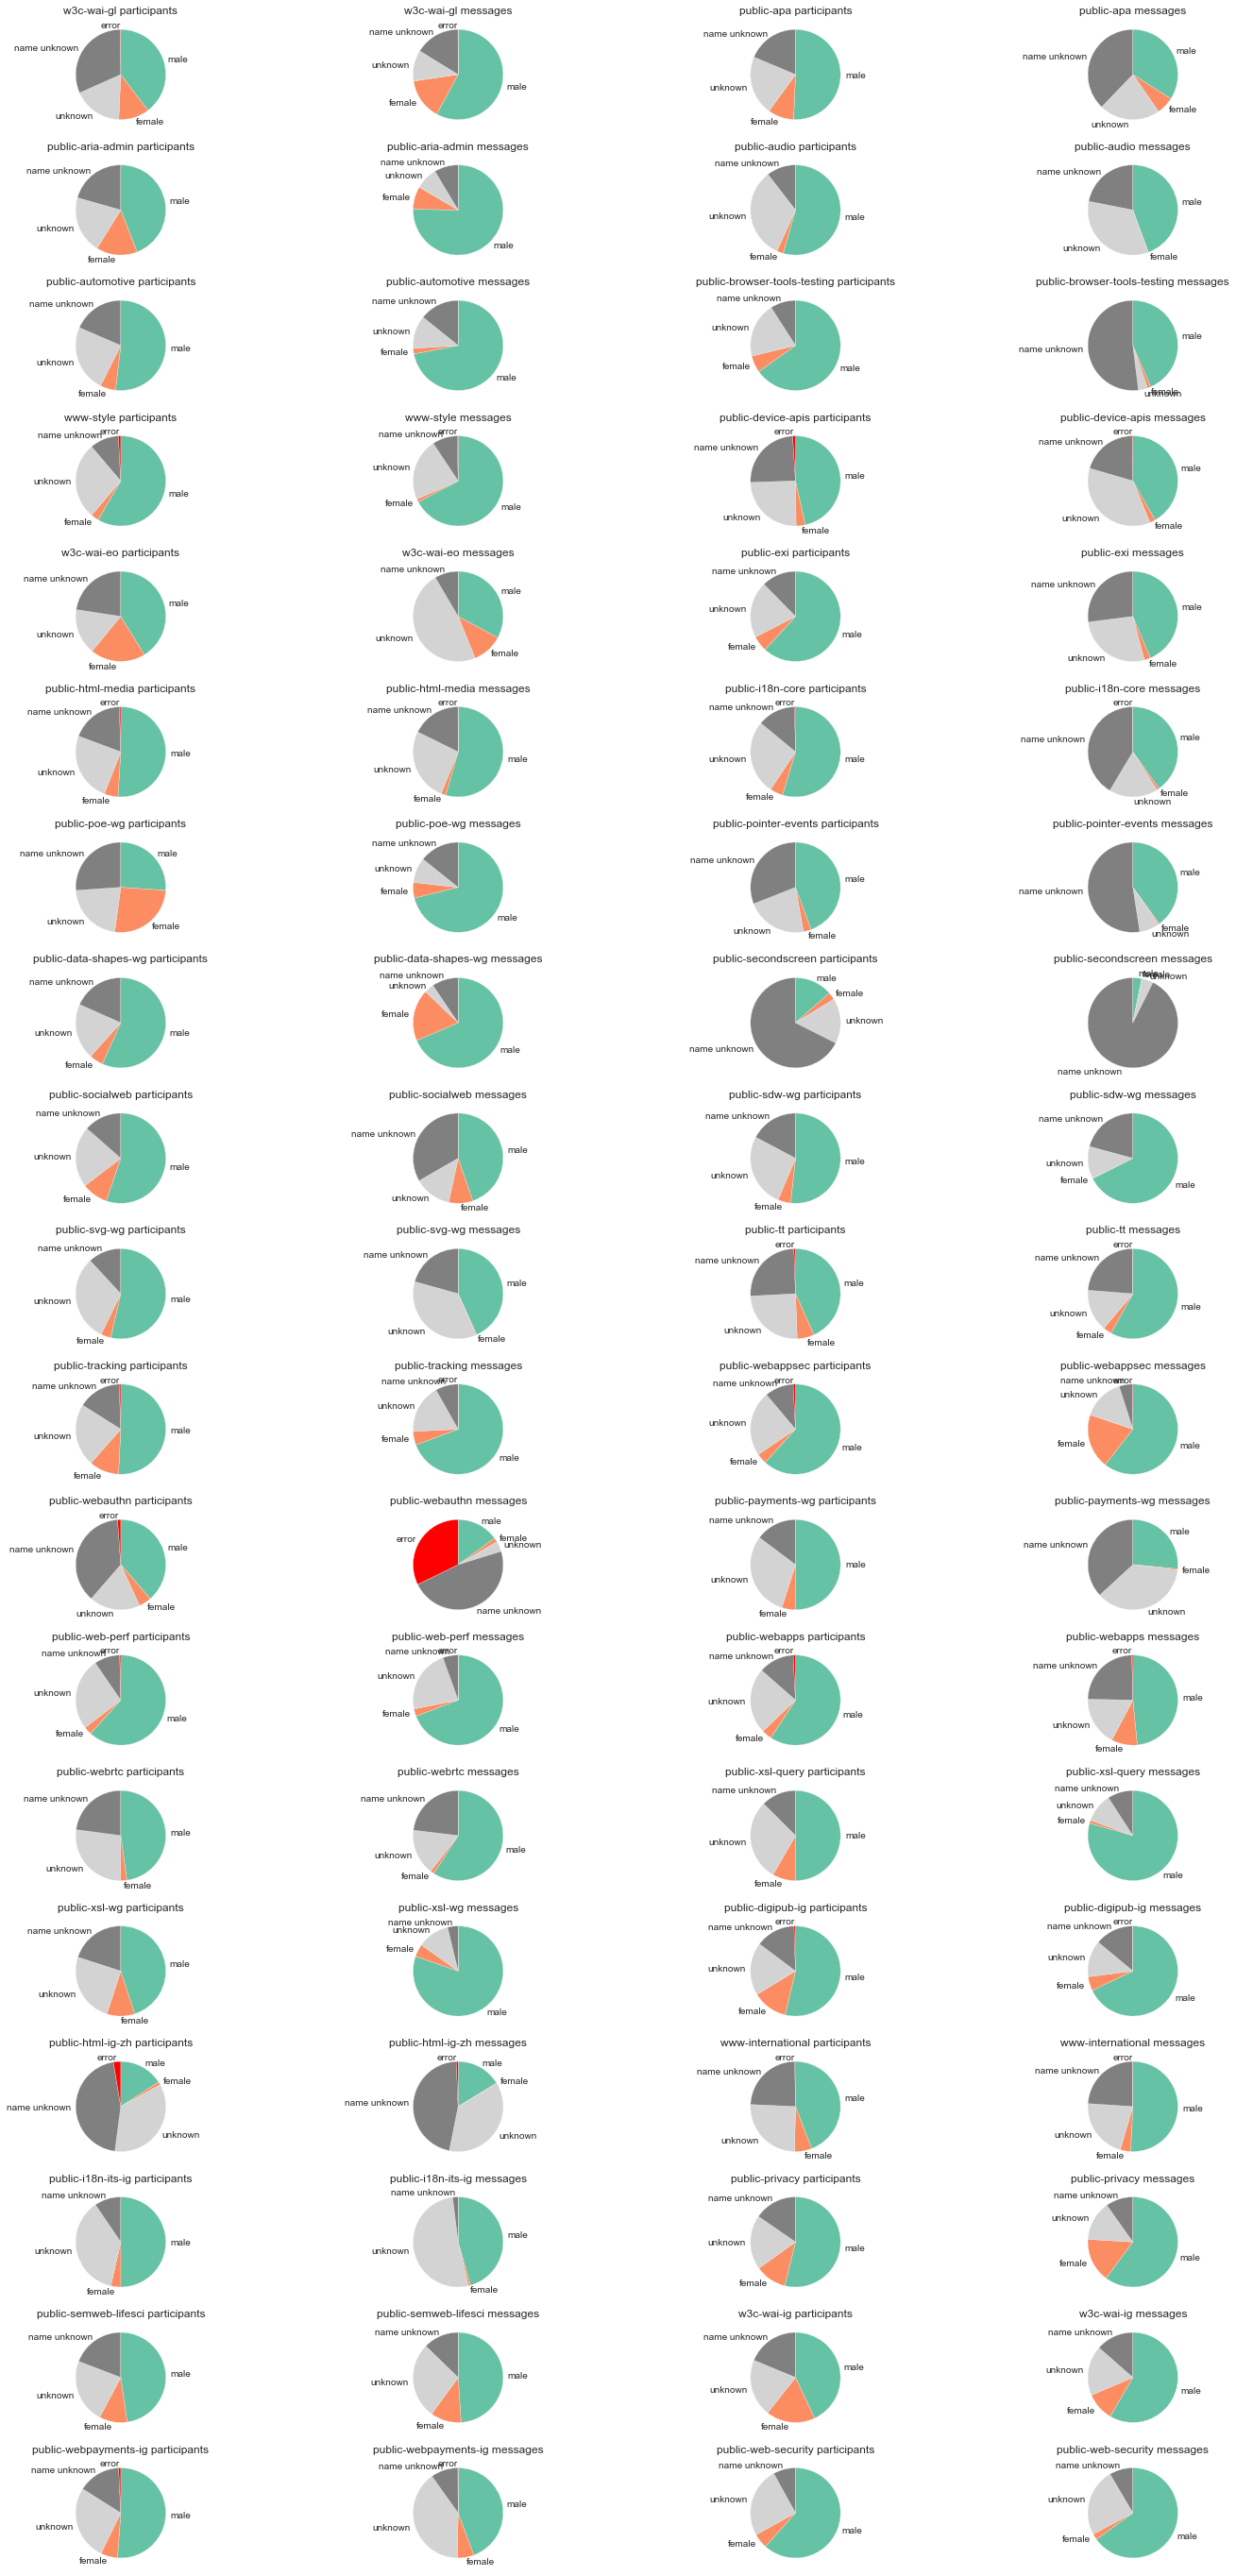

In [169]:
# define consistent colors for each label, avoiding stereotypes, to be consistent across charts
qualitative_color_mapping = {'male':'#66c2a5', 
                             'female':'#fc8d62', 
                             'error':'red', 
                             'unknown':'lightgray', 
                             'name unknown':'gray'}
# from ColorBrewer ['#66c2a5','#fc8d62','#8da0cb'], 
# ... a 3-class qualitative color map that is colorblind friendly and print safe

def colors_for_labels(labels):
    return [qualitative_color_mapping[l] for l in labels]
gender_label_ordering = ['male','female','unknown','name unknown', 'error']

i = 1
cols = 4
rows = len(genderFrame.index)/2 + 1
fig = plt.figure(figsize=(20,40))

for ind, ser in genderFrame.iterrows():
    ax = plt.subplot(rows, cols, i)
    participants = ser['participants']
    participants = participants.reindex(gender_label_ordering)
    participants.plot(kind='pie', colors=colors_for_labels(participants.index), startangle=90, counterclock=False)
    ax.set_aspect('equal')
    ax.set_title(ml_shortname(ser.name) + ' participants')
    ax.set_ylabel('')
    i+=1

    ax = plt.subplot(rows, cols, i)
    messages = ser['message count']
    messages = messages.reindex(gender_label_ordering)
    messages.plot(kind='pie', colors=colors_for_labels(messages.index), startangle=90, counterclock=False)
    ax.set_aspect('equal')
    ax.set_title(ml_shortname(ser.name) + ' messages')
    ax.set_ylabel('')
    i+=1
    
plt.tight_layout()
plt.savefig('gender-pies.png', facecolor='w')
plt.show()

In [162]:
participants = genderFrame['participants']
participants['male fraction'] = participants['male'] / participants.sum(1)
participants['female fraction'] = participants['female'] / participants.sum(1)
participants['unknown fraction'] = (participants['unknown'] + participants['name unknown']) / participants.sum(1)

participants = participants.reset_index()
participants['shortname'] = participants.apply(lambda x: mailman.get_list_name(x['index']), axis=1)

participants = participants.sort_values(by='male fraction', ascending=False)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

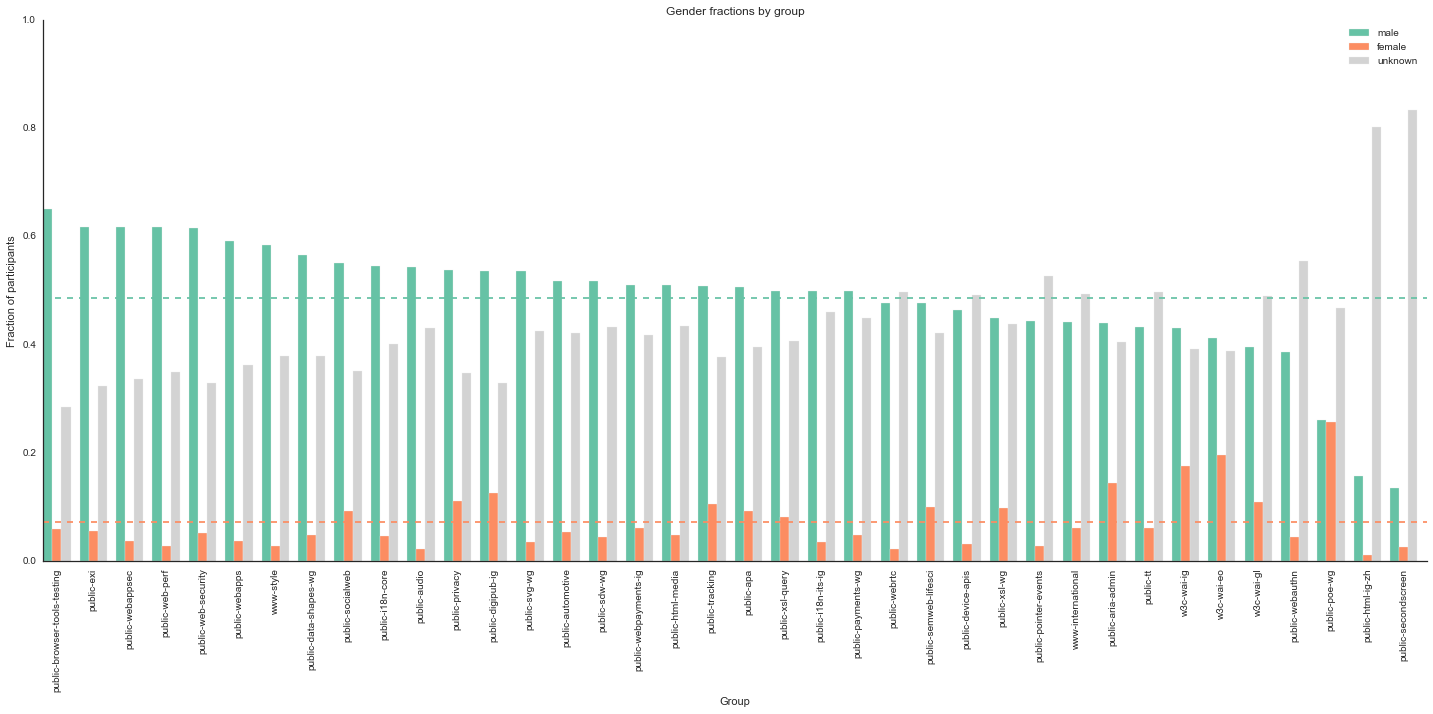

In [168]:
fig = plt.figure(figsize=(20,10))
n_groups = len(participants.index)
index = np.arange(n_groups)
bar_width = 0.25

bar_variables = ['male', 'female', 'unknown']

for (i,value) in zip(range(len(bar_variables)), bar_variables):
    rects1 = plt.bar(index + (bar_width * i), participants[value + ' fraction'], bar_width,
                     color=qualitative_color_mapping[value],
                     label=value)

plt.xlabel('Group')
plt.ylabel('Fraction of participants')
plt.title('Gender fractions by group')
plt.xticks(index + bar_width * 1.5, participants['shortname'], rotation='vertical')
plt.ylim(top=1)

qualitative_color_mapping

plt.hlines([participants['male fraction'].mean(), participants['female fraction'].mean()],
           0, n_groups, 
           colors=[qualitative_color_mapping[x] for x in ['male','female']], 
           linestyles='dashed')
plt.legend()

plt.tight_layout()
sns.despine()

plt.savefig('gender-fraction-bars.png', facecolor='w')
plt.show()